<a href="https://colab.research.google.com/github/rajlm10/D2L-Torch/blob/main/D2L_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q d2l

     |████████████████████████████████| 82 kB 488 kB/s 
     |████████████████████████████████| 61 kB 6.9 MB/s 
     |████████████████████████████████| 11.2 MB 47.6 MB/s 
     |████████████████████████████████| 9.9 MB 43.8 MB/s 
     |████████████████████████████████| 900 kB 60.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
import torch
from d2l import torch as d2l

In [2]:
import shutil

import requests

url = r'https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/catdog.jpg'
response = requests.get(url, stream=True)
with open('catdog.jpg', 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)
del response


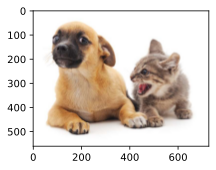

In [3]:
d2l.set_figsize()
img = d2l.plt.imread('/content/catdog.jpg') 
d2l.plt.imshow(img);

# Bounding Boxes

In object detection, we usually use a bounding box to describe the spatial location of an object. The bounding box is rectangular, which is determined by the x and y coordinates of the upper-left corner of the rectangle and the such coordinates of the lower-right corner. Another commonly used bounding box representation is the (x, y)-axis coordinates of the bounding box center, and the width and height of the box.
Here we define functions to convert between these two representations: box_corner_to_center converts from the two-corner representation to the center-width-height presentation, and box_center_to_corner vice versa. The input argument boxes should be a two-dimensional tensor of shape (n, 4), where n is the number of bounding boxes.

In [4]:
def box_corner_to_center(boxes):
  """Convert from (upper-left, lower-right) to (center, width, height).""" 
  x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
  cx = (x1 + x2) / 2
  cy = (y1 + y2) / 2
  w = x2 - x1
  h = y2 - y1
  boxes = torch.stack((cx, cy, w, h), axis=-1)
  return boxes # n X 4

def box_center_to_corner(boxes):
  """Convert from (center, width, height) to (upper-left, lower-right).""" 
  cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
  x1 = cx - 0.5 * w
  y1 = cy - 0.5 * h
  x2 = cx + 0.5 * w
  y2 = cy + 0.5 * h
  boxes = torch.stack((x1, y1, x2, y2), axis=-1)
  return boxes # n X 4

The origin of the coordinates in the image is the upper-left corner of the image, and to the right and down are the positive directions of the x and y axes, respectively.

In [5]:
# x1,y1,x2,y2 format
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [6]:
def bbox_to_rect(bbox, color):
  """Convert bounding box to matplotlib format."""
  # Convert the bounding box (upper-left x, upper-left y, lower-right x, lower-right y) 
  #format to the matplotlib format: ((upper-left x, upper-left y), width, height)
  return d2l.plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
                           fill=False, edgecolor=color, linewidth=2)

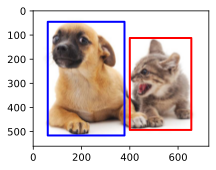

In [7]:
fig = d2l.plt.imshow(img) 
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue')) 
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

# Anchor Boxes

Suppose that the input image has a height of h and width of w. We generate anchor boxes with different shapes centered on each pixel of the image. Let the scale be s ∈ (0, 1] and the aspect ratio (ratio of width to height) is r > 0. **Then the width and height of the anchor box are ws√r and hs/√r, respectively.** 

Note that when the center position is given, an anchor box with known width and height is determined.

To generate multiple anchor boxes with different shapes, let us set a series of scales s1, . . . , sn and a series of aspect ratios r1, . . . , rm. 

When using all the combinations of these scales and aspect ratios with each pixel as the center, the input image will have a total of **whnm** anchor boxes. Although these anchor boxes may cover all the ground-truth bounding boxes, the computational complexity is easily too high. In practice, we can only consider those combinations containing s1 or r1:
(s1, r1), (s1, r2), . . . , (s1, rm), (s2, r1), (s3, r1), . . . , (sn, r1).


That is to say, the number of anchor boxes centered on the same pixel is n + m − 1. For the entire input image, we will generate **wh(n + m − 1)** anchor boxes.

In [8]:
x = torch.tensor([1, 2, 3])
y = torch.tensor([4, 5, 6])

grid_x, grid_y = torch.meshgrid(x, y)

print(grid_x)
grid_y


tensor([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]])


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[4, 5, 6],
        [4, 5, 6],
        [4, 5, 6]])

In [9]:
def multibox_prior(data, sizes, ratios):
  """Generate anchor boxes with different shapes centered on each pixel.""" 
  in_height, in_width = data.shape[-2:]
  device, num_sizes, num_ratios = data.device, len(sizes), len(ratios) 
  boxes_per_pixel = (num_sizes + num_ratios - 1)
  size_tensor = torch.tensor(sizes, device=device)
  ratio_tensor = torch.tensor(ratios, device=device)
  # Offsets are required to move the anchor to the center of a pixel. Since 
  # a pixel has height=1 and width=1, we choose to offset our centers by 0.5 
  offset_h, offset_w = 0.5, 0.5
  steps_h = 1.0 / in_height # Scaled steps in y axis
  steps_w = 1.0 / in_width # Scaled steps in x axis

  # Generate all center points for the anchor boxes
  center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h 
  center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w 
  shift_y, shift_x = torch.meshgrid(center_h, center_w)
  shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

  # Generate `boxes_per_pixel` number of heights and widths that are later 
  # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax) 
  w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),sizes[0] * torch.sqrt(ratio_tensor[1:])))* in_height / in_width  # Handle rectangular inputs 
  h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),sizes[0] / torch.sqrt(ratio_tensor[1:]))) 
  # Divide by 2 to get half height and half width
  anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat( in_height * in_width, 1) / 2

  # Each center point will have `boxes_per_pixel` number of anchor boxes, so 
  # generate a grid of all anchor box centers with `boxes_per_pixel` repeats 
  out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],dim=1).repeat_interleave(boxes_per_pixel, dim=0) 
  output = out_grid + anchor_manipulations
  return output.unsqueeze(0) #returns (1,wh(n+m-1),4)

In [10]:
h, w = img.shape[:2]
print(h, w)

X = torch.rand(size=(1, 3, h, w)) # Construct input data
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5]) 
Y.shape

561 728


torch.Size([1, 2042040, 4])

In [11]:
561*728*(3+3-1) # wh(n+m-1)

2042040

After changing the shape of the anchor box variable Y to (image height, image width, number of anchor boxes centered on the same pixel, 4), we can obtain all the anchor boxes centered on a specified pixel position. In the following, we access the first anchor box centered on (250, 250). It has four elements: the (x, y)-axis coordinates at the upper-left corner and the (x, y)-axis coordinates at the lower-right corner of the anchor box. The coordinate values of both axes are divided by the width and height of the image, respectively; thus, the range is between 0 and 1.

In [12]:
n=m=3
boxes = Y.reshape(h, w, n+m-1, 4) 
boxes.shape

torch.Size([561, 728, 5, 4])

In [13]:
#For pixel 250,250 first bounding box
boxes[250, 250, 0, :]

tensor([0.0551, 0.0715, 0.6331, 0.8215])

In [14]:
def show_bboxes(axes, bboxes, labels=None, colors=None): 
  """Show bounding boxes."""
  def make_list(obj, default_values=None): 
    if obj is None:
      obj = default_values
    elif not isinstance(obj, (list, tuple)):
      obj = [obj]
    
    return obj
  labels = make_list(labels)
  colors = make_list(colors, ['b', 'g', 'r', 'm', 'c']) 
  for i, bbox in enumerate(bboxes):
    color = colors[i % len(colors)]
    rect = d2l.bbox_to_rect(bbox.detach().numpy(), color) 
    axes.add_patch(rect)
    if labels and len(labels) > i:
      text_color = 'k' if color == 'w' else 'w' 
      axes.text(rect.xy[0], rect.xy[1], labels[i],va='center', ha='center', fontsize=9, color=text_color, bbox=dict(facecolor=color, lw=0))

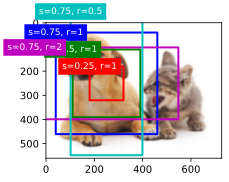

In [15]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h)) #Scale x1,y1 and x2,y2
fig = d2l.plt.imshow(img)

show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2','s=0.75, r=0.5'])

# Intersection Over Union

In [16]:
def box_iou(boxes1, boxes2):
  """Compute pairwise IoU across two lists of anchor or bounding boxes.""" 
  # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`: 
  #(no. of boxes1, 4),(no. of boxes2, 4), (no. of boxes1,), (no. of boxes2,)
  box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *(boxes[:, 3] - boxes[:, 1]))
  areas1 = box_area(boxes1)
  areas2 = box_area(boxes2)
  # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`: 
  #(no. of boxes1, no. of boxes2, 2)
  inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2]) 
  inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
  inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
  # Shape of `inter_areas` and `union_areas`: (no. of boxes1, no. of boxes2) 
  inter_areas = inters[:, :, 0] * inters[:, :, 1]
  union_areas = areas1[:, None] + areas2 - inter_areas
  return inter_areas / union_areas

# Labelling Anchor Boxes 

In a training dataset, we consider each anchor box as a training example. In order to train an object detection model, we need class and offset labels for each anchor box, where the former is the class of the object relevant to the anchor box and the latter is the offset of the ground-truth bounding box relative to the anchor box. During the prediction, for each image we generate multiple anchor boxes, predict classes and offsets for all the anchor boxes, adjust their positions according to the predicted offsets to obtain the predicted bounding boxes, and finally only output those predicted bounding boxes that satisfy certain criteria.

As we know, an object detection training set comes with labels for locations of ground-truth bound- ing boxes and classes of their surrounded objects. To label any generated anchor box, we refer to the labeled location and class of its assigned ground-truth bounding box that is closest to the anchor box. In the following, we describe an algorithm for assigning closest ground-truth bounding boxes to anchor boxes.

##Algorithm

Given an image,suppose that the anchor boxes are A1,A2,...,An_a and the ground-truth bounding boxes are B1,B2,...,Bn_b, where n_a ≥ n_b. Let us define a matrix X ∈ Rn_a×n_b, whose element xij in the ith row and jth column is the IoU of the anchor box Ai and the ground-truth bounding box Bj . The algorithm consists of the following steps:

1. Find the largest element in matrix X and denote its row and column indices as i1 and j1, respectively. Then the ground-truth bounding box Bj1 is assigned to the anchor box Ai1 . This is quite intuitive because Ai1 and Bj1 are the closest among all the pairs of anchorboxes and ground-truth bounding boxes. After the first assignment, discard all the elements in the i1th row and the j1th column in matrix X.

2. Find the largest of the remaining elements in matrix X and denote its row and column indices as i2 and j2, respectively. We assign ground-truth bounding box Bj2 to anchor box Ai2 and discard all the elements in the i2th row and the j2th column in matrix X.

3. At this point, elements in two rows and two columns in matrix X have been discarded. We proceed until all elements in nb columns in matrix X are discarded. At this time, we have assigned a ground-truth bounding box to each of nb anchor boxes.

4. Only traverse through the remaining na − nb anchor boxes. For example, given any anchor box Ai, find the ground-truth bounding box Bj with the largest IoU with Ai throughout the ith row of matrix X, and assign Bj to Ai only if this IoU is greater than a predefined threshold.






In [17]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5): 
  """Assign closest ground-truth bounding boxes to anchor boxes.""" 
  num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
  # Element x_ij in the i-th row and j-th column is the IoU of the anchor 
  # box i and the ground-truth bounding box j
  jaccard = box_iou(anchors, ground_truth) #num_anchors X num_gts
  print('IOUs: ',jaccard)


  # Initialize the tensor to hold the assigned ground-truth bounding box for each anchor
  anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,device=device)
  #Note that max_ious & indices would be of the len num_anchors
  max_ious, indices = torch.max(jaccard, dim=1)

  #Returns tensor of len n where n<= num_anchors since we leave the ones   
  #that are zero or below iou_threshold
  anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)


  print('anc_i: ',anc_i)
 
  #Those indices where max_iou is above iou_threshold
  box_j = indices[max_ious >= iou_threshold]
  print('box_j: ',box_j)


  #Map all anchor boxes that are non_zero and have IOU>=0.5 with any GT box
  # to the gt box that has the max IOU overlap with it (provided its > 0.5)
  anchors_bbox_map[anc_i] = box_j
  col_discard = torch.full((num_anchors,), -1) 
  row_discard = torch.full((num_gt_boxes,), -1)

  print('Before Loop: ',anchors_bbox_map)

  #So now we have completed step 4

  #At this point the reason we must execute steps 1-3 is to ensure
  # that every ground truth box has a mapping to an anchor box
  #Even if the IOU is 0, we do not leave out any ground truth box
  #On the other hand the anchor box may be left out and assigned 
  # the background label if there exist other,more suitable anchor boxes
  #for a particular gt box
  #Now moving onto steps 1-3
  for _ in range(num_gt_boxes):
    max_idx = torch.argmax(jaccard) # Find the largest IoU 

    #If dim=None (i.e default), the argmax of the flattened input is returned.
    box_idx = (max_idx % num_gt_boxes).long()
    anc_idx = (max_idx / num_gt_boxes).long() #int64
    anchors_bbox_map[anc_idx] = box_idx
    jaccard[:, box_idx] = col_discard
    jaccard[anc_idx, :] = row_discard 
  print('After Loop: ',anchors_bbox_map)
  
  return anchors_bbox_map



## Labeling classes and offsets

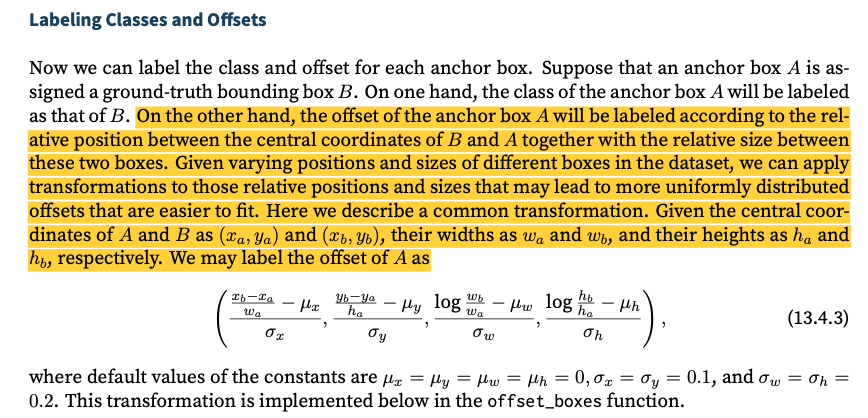

In [18]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
  """Transform for anchor box offsets."""
  c_anc = box_corner_to_center(anchors)
  c_assigned_bb = box_corner_to_center(assigned_bb)
  offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:] 
  offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:]) 
  offset = torch.cat([offset_xy, offset_wh], axis=1)
  return offset

If an anchor box is not assigned a ground-truth bounding box, we just label the class of the anchor box as “background”. Anchor boxes whose classes are background are often referred to as negative anchor boxes, and the rest are called positive anchor boxes. We implement the following multi- box_target function to label classes and offsets for anchor boxes (the anchors argument) using ground-truth bounding boxes (the labels argument). This function sets the background class to zero and increments the integer index of a new class by one.

In [19]:
def multibox_target(anchors, labels):
  """Label anchor boxes using ground-truth bounding boxes.""" 
  batch_size, anchors = labels.shape[0], anchors.squeeze(0) 
  batch_offset, batch_mask, batch_class_labels = [], [], [] 
  device, num_anchors = anchors.device, anchors.shape[0]
  for i in range(batch_size):
    label = labels[i, :, :]
    #Position 0 in label is for the class label
    #And 1: denotes box coordinates
    anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors, device)
    bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
    # Initialize class labels and assigned bounding box coordinates with # zeros
    class_labels = torch.zeros(num_anchors, dtype=torch.long,device=device)
    assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,device=device)
    # Label classes of anchor boxes using their assigned ground-truth
    # bounding boxes. If an anchor box is not assigned any, we label its 
    # class as background (the value remains zero)
    indices_true = torch.nonzero(anchors_bbox_map >= 0)
    bb_idx = anchors_bbox_map[indices_true]
    class_labels[indices_true] = label[bb_idx, 0].long() + 1 
    assigned_bb[indices_true] = label[bb_idx, 1:]
    # Offset transformation
    offset = offset_boxes(anchors, assigned_bb) * bbox_mask 
    batch_offset.append(offset.reshape(-1)) 
    batch_mask.append(bbox_mask.reshape(-1)) 
    batch_class_labels.append(class_labels)
  bbox_offset = torch.stack(batch_offset) 
  bbox_mask = torch.stack(batch_mask) 
  class_labels = torch.stack(batch_class_labels) 
  return (bbox_offset, bbox_mask, class_labels)

## An example


Let us illustrate anchor box labeling via a concrete example. We define ground-truth bounding boxes for the dog and cat in the loaded image, where the first element is the class (0 for dog and 1 for cat) and the remaining four elements are the (x, y)-axis coordinates at the upper-left corner and the lower-right corner (range is between 0 and 1). We also construct five anchor boxes to be labeled using the coordinates of the upper-left corner and the lower-right corner: A0, . . . , A4 (the index starts from 0). Then we plot these ground-truth bounding boxes and anchor boxes in the image.

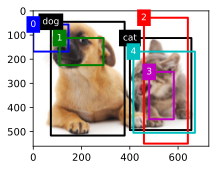

In [20]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92], [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],[0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8], [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k') 
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In this example, indices of the background, dog, and cat classes are 0, 1, and 2, respectively. Below we add an dimension for examples of anchor boxes and ground-truth bounding boxes.

In [21]:
labels = multibox_target(anchors.unsqueeze(dim=0), ground_truth.unsqueeze(dim=0))

IOUs:  tensor([[0.0536, 0.0000],
        [0.1417, 0.0000],
        [0.0000, 0.5657],
        [0.0000, 0.2059],
        [0.0000, 0.7459]])
anc_i:  tensor([2, 4])
box_j:  tensor([1, 1])
Before Loop:  tensor([-1, -1,  1, -1,  1])
After Loop:  tensor([-1,  0,  1, -1,  1])


There are three items in the returned result, all of which are in the tensor format. 

The first returned item contains the four offset values labeled for each anchor box. Note that the offsets of negative-class anchor boxes are labeled as zeros.

The second returned item is a mask variable of the shape (batch size, four times the number of anchor boxes). Every four elements in the mask variable correspond to the four offset values of each anchor box. Since we do not care about background detection, offsets of this negative class should not affect the objective function. Through elementwise multiplications, zeros in the mask variable will filter out negative class offsets before calculating the objective function.

The third item contains the labeled classes of the input anchor boxes.
Let us analyze the returned class labels below based on anchor box and ground-truth bounding box positions in the image. First, among all the pairs of anchor boxes and ground-truth bounding boxes, the IoU of the anchor box A4 and the ground-truth bounding box of the cat is the largest. Thus, the class of A4 is labeled as the cat. Taking out pairs containing A4 or the ground-truth bounding box of the cat, among the rest the pair of the anchor box A1 and the ground-truth bound- ing box of the dog has the largest IoU. So the class of A1 is labeled as the dog. Next, we need to traverse through the remaining three unlabeled anchor boxes: A0, A2, and A3. For A0, the class of the ground-truth bounding box with the largest IoU is the dog, but the IoU is below the predefined threshold (0.5), so the class is labeled as background; for A2, the class of the ground-truth bound- ing box with the largest IoU is the cat and the IoU exceeds the threshold, so the class is labeled as the cat; for A3, the class of the ground-truth bounding box with the largest IoU is the cat, but the value is below the threshold, so the class is labeled as background.

In [22]:
labels

(tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,  1.4000e+00,
           1.0000e+01,  2.5940e+00,  7.1754e+00, -1.2000e+00,  2.6882e-01,
           1.6824e+00, -1.5655e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -5.7143e-01, -1.0000e+00,  4.1723e-06,  6.2582e-01]]),
 tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
          1., 1.]]),
 tensor([[0, 1, 2, 0, 2]]))

# Non-Max Supression



During prediction, we generate multiple anchor boxes for the image and predict classes and off- sets for each of them. A predicted bounding box is thus obtained according to an anchor box with its predicted offset. Below we implement the offset_inverse function that takes in anchors and off- set predictions as inputs and applies inverse offset transformations to return the predicted bounding box coordinates.

In [23]:
def offset_inverse(anchors, offset_preds):
  """Predict bounding boxes based on anchor boxes with predicted offsets.""" 
  anc = box_corner_to_center(anchors)
  pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2] 
  pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
  pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
  predicted_bbox = box_center_to_corner(pred_bbox)
  return predicted_bbox

**When there are many anchor boxes, many similar (with significant overlap) predicted bounding boxes can be potentially output for surrounding the same object. To simplify the output, we can merge similar predicted bounding boxes that belong to the same object by using non-maximum suppression (NMS).**


Here is how non-maximum suppression works. For a predicted bounding box B, the object detec- tion model calculates the predicted likelihood for each class. Denoting by p the largest predicted likelihood, the class corresponding to this probability is the predicted class for B. Specifically, we refer to p as the confidence (score) of the predicted bounding box B. On the same image, all the predicted non-background bounding boxes are sorted by confidence in descending order to generate a list L. Then we manipulate the sorted list L in the following steps:

1. Select the predicted bounding box B1 with the highest confidence from L as a basis and remove all non-basis predicted bounding boxes whose IoU with B1 exceeds a predefined threshold ε from L. At this point, L keeps the predicted bounding box with the highest con- fidence but drops others that are too similar to it. In a nutshell, those with non-maximum confidence scores are suppressed.

2. Select the predicted bounding box B2 with the second highest confidence from L as another basis and remove all non-basis predicted bounding boxes whose IoU with B2 exceeds ε from L.

3. Repeat the above process until all the predicted bounding boxes in L have been used as a basis. At this time, the IoU of any pair of predicted bounding boxes in L is below the threshold ε; thus, no pair is too similar with each other.
4. Output all the predicted bounding boxes in the list L.

In [25]:
def nms(boxes, scores, iou_threshold):
  """Sort confidence scores of predicted bounding boxes."""
  B = torch.argsort(scores, dim=-1, descending=True)
  keep = [] # Indices of predicted bounding boxes that will be kept 
  while B.numel() > 0:
    i = B[0]
    keep.append(i)
    if B.numel() == 1: 
      break
    #Every box except itself  
    iou = box_iou(boxes[i, :].reshape(-1, 4),boxes[B[1:], :].reshape(-1, 4)).reshape(-1) 
    inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
    B = B[inds + 1]
  return torch.tensor(keep, device=boxes.device)

In [26]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5, pos_threshold=0.009999999):
  """Predict bounding boxes using non-maximum suppression."""
  device, batch_size = cls_probs.device, cls_probs.shape[0]
  anchors = anchors.squeeze(0)
  num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2] 
  out = []
  for i in range(batch_size):
    cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4) 
    conf, class_id = torch.max(cls_prob[1:], 0)
    predicted_bb = offset_inverse(anchors, offset_pred)
    keep = nms(predicted_bb, conf, nms_threshold)
    # Find all non-`keep` indices and set the class to background 
    all_idx = torch.arange(num_anchors, dtype=torch.long, device=device) 
    combined = torch.cat((keep, all_idx))
    uniques, counts = combined.unique(return_counts=True)
    non_keep = uniques[counts == 1]
    all_id_sorted = torch.cat((keep, non_keep))
    class_id[non_keep] = -1
    class_id = class_id[all_id_sorted]
    conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted] 
    # Here `pos_threshold` is a threshold for positive (non-background)
    # predictions
    below_min_idx = (conf < pos_threshold)
    class_id[below_min_idx] = -1
    conf[below_min_idx] = 1 - conf[below_min_idx]
    pred_info = torch.cat((class_id.unsqueeze(1),conf.unsqueeze(1), predicted_bb), dim=1)
    out.append(pred_info) 
  return torch.stack(out)

Now let us apply the above implementations to a concrete example with four anchor boxes. For simplicity, we assume that the predicted offsets are all zeros. This means that the predicted bounding boxes are anchor boxes. For each class among the background, dog, and cat, we also define its predicted likelihood.

In [27]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95], [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4, # Predicted background likelihood
[0.9, 0.8, 0.7, 0.1], # Predicted dog likelihood 
[0.1, 0.2, 0.3, 0.9]])# Predicted cat likelihood

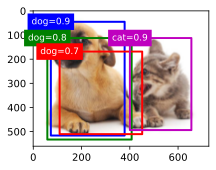

In [28]:
fig = d2l.plt.imshow(img) 
show_bboxes(fig.axes, anchors * bbox_scale,['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

**We can see that the shape of the returned result is (batch size, number of anchor boxes, 6). The six elements in the innermost dimension gives the output information for the same predicted bound- ing box. The first element is the predicted class index, which starts from 0 (0 is dog and 1 is cat).**

**The value -1 indicates background or removal in non-maximum suppression. The second element is the confidence of the predicted bounding box. The remaining four elements are the (x, y)-axis coordinates of the upper-left corner and the lower-right corner of the predicted bounding box, respectively (range is between 0 and 1).**

In [29]:
output = multibox_detection(cls_probs.unsqueeze(dim=0), offset_preds.unsqueeze(dim=0),anchors.unsqueeze(dim=0), nms_threshold=0.5)
output


tensor([[[ 0.0000,  0.9000,  0.1000,  0.0800,  0.5200,  0.9200],
         [ 1.0000,  0.9000,  0.5500,  0.2000,  0.9000,  0.8800],
         [-1.0000,  0.8000,  0.0800,  0.2000,  0.5600,  0.9500],
         [-1.0000,  0.7000,  0.1500,  0.3000,  0.6200,  0.9100]]])

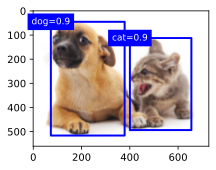

In [30]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
  if i[0] == -1: 
    continue
  label = ('dog=', 'cat=')[int(i[0])] + str(i[1]) 
  show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

In practice, we can remove predicted bounding boxes with lower confidence even before per- forming non-maximum suppression, thereby reducing computation in this algorithm. We may also post-process the output of non-maximum suppression, for example, by only keeping results with higher confidence in the final output.

• We generate anchor boxes with different shapes centered on each pixel of the image.

• Intersection over union (IoU), also known as Jaccard index, measures the similarity of two bounding boxes. It is the ratio of their intersection area to their union area.

• In a training set, we need two types of labels for each anchor box. One is the class of the object relevant to the anchor box and the other is the offset of the ground-truth bounding box relative to the anchor box.

• During prediction, we can use non-maximum suppression (NMS) to remove similar pre- dicted bounding boxes, thereby simplifying the output.